## Bagging & Pasting

* 在不同训练集的随机子集上进行训练
* 若样本有放回，则为 bagging
* 若样本无放回，则为 pasting, sklearn 中设置 bootstrap=False 即为无放回处理
* 若存在 predict_proba()，则执行软投票

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np

In [6]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1 # max_samples 可以设置为 0-1 的浮点数
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [7]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

In [8]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [9]:
print(accuracy_score(y_test, y_pred_tree))

0.816


In [10]:
# 对比 bagging 的边界和决策树边界
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [11]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Text(0, 0.5, '')

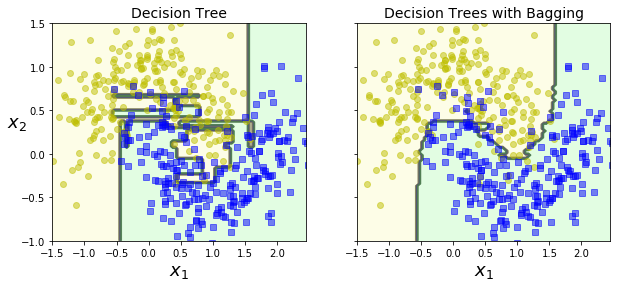

In [12]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")

## 包外评估

* 对各个预测器中未采样的样本进行测试，得到的评估结果称为 out-of-bag evaluation
* 从某种程度上可以反映模型的泛化能力。
* 需要在训练前设置 oob_score=True
* 属性 oob_score_ : 输出包外评估的准确率
* 属性 oob_decision_function : 返回包外决策函数，即对每个变量所有包外的评估结果中，属于某个类别的概率。


In [13]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [14]:
bag_clf.oob_decision_function_

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.71195652, 0.28804348],
       [0.83957219, 0.16042781],
       [0.97777778, 0.02222222],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97297297, 0.02702703],
       [0.95238095, 0.04761905],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.38947368, 0.61052632],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64804469, 0.35195531],
       [0.

In [15]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

## 随机补丁与随机子空间

* 当对高维输入时，我们希望每个预测器不是对所有特征进行训练，而是随机取部分特征。这通过 max_features 和 bootstrap_features 控制。
* 随机补丁：对实例和特征均进行采样的方法；
* 随机子空间：保留所有训练实例（bootstrap=False, max_samples=1.0），仅对特征进行采样
